# Digital Earth Australia Intertidal workflow

## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd ..

/home/jovyan/dea_intertidal/dea-intertidal


Install additional packages directly from the requirements file

In [2]:
pip install -r requirements.in --quiet

Note: you may need to restart the kernel to use updated packages.


### Load packages

In [3]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from ipyleaflet import basemaps, basemap_to_tiles

import datacube
import odc.geo.xr
from odc.geo.geom import Geometry
from odc.algo import mask_cleanup
from odc.ui import select_on_a_map

from intertidal.utils import (
    round_date_strings,
    export_intertidal_rasters,
    intertidal_hillshade,
                            )
from intertidal.tide_modelling import pixel_tides_ensemble
from intertidal.elevation import load_data, load_topobathy, elevation
from intertidal.extents import extents
from intertidal.exposure import exposure
from intertidal.tidal_bias_offset import bias_offset, tidal_offset_tidelines

from dea_tools.dask import create_local_dask_cluster

## Setup


### Set analysis parameters

In [4]:
# Intertidal Elevation variables
start_date = "2020"  # Start date for analysis
end_date = "2022"  # End date for analysis
resolution = 10  # Spatial resolution used for output files
crs = "EPSG:3577"  # Coordinate Reference System (CRS) to use for output files
ndwi_thresh = 0.1  # Threshold used to identify dry/wet transition
include_s2 = True  # Include Sentinel-2 data in the analysis?
include_ls = True  # Include Landsat data in the analysis?
filter_gqa = True  # Filter to remove poorly georeferenced scenes?
tide_model = "ensemble"  # Tide model to use in analysis
tide_model_dir = "/gdata1/data/tide_models_clipped"

# Exposure variables
modelled_freq = "3h"  # Frequency to run tidal model e.g '30min' or '1h'
# filters=[None] # Exposure filters.
# filters_combined = None ## Must be a list of tuples containing one temporal and spatial filter each

# # Generate range of times covering entire period of satellite record for exposure and bias/offset calculation
# all_timerange = pd.date_range(
#     start=round_date_strings(start_date, round_type="start"),
#     end=round_date_strings(end_date, round_type="end"),
#     freq=modelled_freq,
# )

#### Set study area

In [ ]:
# ##TEMP - recall stored validation geometry object to set geom for elevation calculation
# %store -r ds

# geom = ds.geobox.geographic_extent

##### Option 1: load study area from 32 km tile GridSpec

In [ ]:
# # Set study area (e.g. tile ID in form 'x143y87')
# study_area = "x139y96"
# geom = None  # Use GridSpec to load study area, not a custom geom

##### Option 2: load study area from vector file

In [ ]:
# # Set study area to load from file
# study_area = "pointstuart"

# # Read file, select study area and convert to geom
# studyarea_gdf = gpd.read_file(
#     "data/raw/intertidal_development_polygons.geojson"
# ).set_index("id")
# geom = Geometry(studyarea_gdf.loc[study_area].geometry, crs=studyarea_gdf.crs)
# geom

##### Option 3: load study area using interactive map

Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

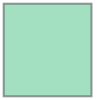

In [5]:
# Set study area name for outputs
study_area = "test"

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geom = select_on_a_map(height="600px", layers=(basemap,), center=(-26, 135), zoom=4)
geom

## Intertidal workflow

### Load data

In [6]:
%%time

# Connect to datacube
dc = datacube.Datacube(app="Intertidal_elevation")

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

satellite_ds = load_data(
    dc=dc,
    study_area=study_area,
    geom=geom,
    time_range=(start_date, end_date),
    resolution=resolution,
    crs=crs,
    include_s2=True,
    
    include_ls=True,
    filter_gqa=filter_gqa,
    max_cloudcover=90,
    skip_broken_datasets=True,
)

print(satellite_ds)

# Load data
satellite_ds.load()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 15,Total memory: 117.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37581,Workers: 1
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,Total threads: 15
Started: Just now,Total memory: 117.21 GiB
Comm: tcp://127.0.0.1:46491,Total threads: 15
Dashboard: /user/claire.phillips@ga.gov.au/proxy/42263/status,Memory: 117.21 GiB
Nanny: tcp://127.0.0.1:36407,


<xarray.Dataset>
Dimensions:      (time: 325, y: 237, x: 215)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-01T01:55:31.756059 ... 2022-12...
  * y            (y) float64 -2.304e+06 -2.304e+06 ... -2.306e+06 -2.306e+06
  * x            (x) float64 -1.598e+06 -1.598e+06 ... -1.596e+06 -1.596e+06
    spatial_ref  int32 3577
Data variables:
    ndwi         (time, y, x) float32 dask.array<chunksize=(1, 237, 215), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


CPU times: user 5.23 s, sys: 504 ms, total: 5.73 s
Wall time: 37.1 s


<xarray.Dataset>
Dimensions:      (time: 325, y: 237, x: 215)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-01T01:55:31.756059 ... 2022-12...
  * y            (y) float64 -2.304e+06 -2.304e+06 ... -2.306e+06 -2.306e+06
  * x            (x) float64 -1.598e+06 -1.598e+06 ... -1.596e+06 -1.596e+06
    spatial_ref  int32 3577
Data variables:
    ndwi         (time, y, x) float32 nan nan nan ... -0.1535 -0.1542 -0.1555
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

### Load optional topobathy mask
Loads a topo-bathymetric DEM for the extents of the loaded satellite data.
This is used as a coarse mask to constrain the analysis to the coastal zone, improving run time and reducing clear false positives over deep water or elevated land.

In [7]:
# Load data from GA's Australian Bathymetry and Topography Grid 2009
topobathy_ds = load_topobathy(
    dc, satellite_ds, product="ga_multi_ausbath_0", resampling="bilinear"
)

### Intertidal elevation
To run without the topobathy DEM mask, comment out `valid_mask=...`.

In [8]:
# %reload_ext autoreload

# Model elevation for each pixel
ds, ds_aux, tide_m = elevation(
    satellite_ds,
    valid_mask=topobathy_ds.height_depth > -20,
    tide_model=tide_model,
    tide_model_dir=tide_model_dir,
)

2024-02-01 04:19:28 INFO Modelling tide heights for each pixel


Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014, FES2012, TPXO8-atlas-v1, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10 in parallel


100%|██████████| 35/35 [00:19<00:00,  1.77it/s]


Returning low resolution tide array
Generating ensemble tide model from point inputs


2024-02-01 04:19:52 INFO Masking nodata and adding tide heights to satellite data array
2024-02-01 04:19:53 INFO Flattening satellite data array and filtering to intertidal candidate pixels
2024-02-01 04:19:53 INFO Applying valid data mask to constrain study area
2024-02-01 04:19:53 INFO Running per-pixel rolling median


Reducing analysed pixels from 50955 to 8141 (15.98%)


  0%|          | 0/105 [00:00<?, ?it/s]

2024-02-01 04:20:05 INFO Modelling intertidal elevation
2024-02-01 04:20:05 INFO Modelling intertidal uncertainty


Applying tidal interval interpolation to 200 intervals
Applying rolling mean smoothing with radius 20


2024-02-01 04:20:06 INFO Unflattening data back to its original spatial dimensions
2024-02-01 04:20:06 INFO Cleaning inaccurate upper intertidal pixels
2024-02-01 04:20:06 INFO Successfully completed intertidal elevation modelling


### Intertidal extents


In [9]:
ds["extents"] = extents(
    freq=ds_aux.ndwi_wet_freq, dem=ds.elevation, corr=ds_aux.ndwi_tide_corr
)

In [10]:
# ## Plot with labels
# labels=['0 Dry',
#        '1 Intermittent\n   wet\n   inland',
#        '2 Wet inland',
#        '3 Wet ocean',
#        '4 Intertidal lc',
#        '5 Intertidal hc',
#        ]

# fig,ax=plt.subplots(figsize=(12,8))
# cax=ax.imshow(ds['extents'], cmap='terrain_r')
# cbar=fig.colorbar(cax, ticks=[0,1,2,3,4,5])
# cbar.ax.set_yticklabels(labels)
# plt.show()

### Intertidal exposure
Calculate exposure using the script function.
To calculate exposure for the full time period, leave `filters` commented out or set as ['unfiltered'].
See the function documentation for the full range of available filters and filter_combinations.
The code accepts lists of multiple filters and filter_combination tuples.

In [16]:
%reload_ext autoreload

exposure_filters, tide_cq_dict = exposure(
    dem=ds.elevation,
    start_date=start_date,
    end_date=end_date,
    modelled_freq = modelled_freq,
    tide_model=tide_model,
    tide_model_dir=tide_model_dir,
    # filters=filters,
    # filters_combined=filters_combined,
)

for x in list(exposure_filters.keys()):
    ds['exposure_'+str(x)]=exposure_filters[str(x)]

Calculating unfiltered exposure
Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014, FES2012, TPXO8-atlas-v1, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10 in parallel


100%|██████████| 35/35 [00:19<00:00,  1.78it/s]


Computing tide quantiles
Returning low resolution tide array
Generating ensemble tide model from point inputs


### Spread and offset
Calculate the spread and high/low tide biases of input observed images as a percentage of the modelled tide heights.

Warning: this code will only work if the exposure function has been run and produced 'unfiltered' exposure results.


In [ ]:
(
    ds["oa_lat"],
    ds["oa_hat"],
    ds["oa_lot"],
    ds["oa_hot"],
    ds["oa_spread"],
    ds["oa_offset_lowtide"],
    ds["oa_offset_hightide"],
) = bias_offset(
    tide_m=tide_m, tide_cq=tide_cq_dict['unfiltered'], extents=ds.extents, lot_hot=True, lat_hat=True
)

### Tideline confidence

In [ ]:
# (hightideline, lowtideline, tidelines_gdf) = tidal_offset_tidelines(
#     extents=ds.extents,
#     offset_hightide=ds.oa_offset_hightide,
#     offset_lowtide=ds.oa_offset_lowtide,
#     distance=250,
# )

## Plot all layers

In [ ]:
# Inspect contents of ds before plotting
ds

In [ ]:
fig = plt.figure(figsize=(16, 18), tight_layout=True)
ax_dict = fig.subplot_mosaic(
    """
    AAAABBBBCCCC
    DDDEEEFFFGGG
    HHHIIIJJJKKK
    LLLMMM......
    """,
    height_ratios=[1, 0.8, 0.8, 0.8],
)

# label_params = dict(add_labels=False, yticks=[], xticks=[])

# Plot Elevation with hillshade
ds["elevation"].plot.imshow(
    ax=ax_dict["A"],
    cmap="viridis",
    interpolation="bilinear",
)
intertidal_hillshade(ds["elevation"], ds["extents"], vert_exag=300).plot.imshow(
    ax=ax_dict["A"],
    interpolation="bilinear",
)
ax_dict["A"].set_title("Elevation (metres AMSL)")

# Plot uncertainty
ds["elevation_uncertainty"].plot.imshow(
    ax=ax_dict["B"],
    cmap="magma",
    interpolation="bilinear",
)
ax_dict["B"].set_title("Elevation uncertainty (metres)")
ax_dict["B"].set_facecolor("#2E2E2E")

# Plot Exposure
ds["exposure_unfiltered"].plot.imshow(
    ax=ax_dict["C"],
    cmap="RdYlGn",
    levels=np.arange(0, 100, 1),
    add_labels=False,
    yticks=[],
)
ax_dict["C"].set_title("Exposure")

# Plot Extents
ds["extents"].astype(np.int16).plot.imshow(ax=ax_dict["D"])
ax_dict["D"].set_title("Extents")

# Plot the observation spread
ds["oa_spread"].plot.imshow(
    ax=ax_dict["E"],
    vmin=0,
    vmax=100,
    cmap="magma",
    cbar_kwargs={"label": "% of tidal range observed"},
)
ax_dict["E"].set_title("Observation Spread (%)")

# Plot the high-tide offset
ds["oa_offset_hightide"].plot.imshow(
    ax=ax_dict["F"],
    vmin=0,
    vmax=40,
    cmap="magma",
    cbar_kwargs={"label": "% of high tide never observed"},
)
ax_dict["F"].set_title("High-tide offset (%)")

# Plot the low-tide offset
ds["oa_offset_lowtide"].plot.imshow(
    ax=ax_dict["G"],
    vmin=0,
    vmax=40,
    cmap="magma",
    cbar_kwargs={"label": "% of low tide never observed"},
)
ax_dict["G"].set_title("Low-tide offset (%)")

# Plot the LAT
ds["oa_lat"].plot.imshow(
    ax=ax_dict["H"],
    vmin=ds["oa_lat"].min(),
    vmax=ds["oa_hat"].max(),
    add_labels=False,
)
ax_dict["H"].set_title("Lowest Astronomical Tide")

# Plot the LOT
ds["oa_lot"].plot.imshow(
    ax=ax_dict["I"], vmin=ds["oa_lat"].min(), vmax=ds["oa_hat"].max()
)
ax_dict["I"].set_title("Lowest Observed Tide")

# Plot the HAT
ds["oa_hat"].plot.imshow(
    ax=ax_dict["J"],
    vmin=ds["oa_lat"].min(),
    vmax=ds["oa_hat"].max(),
    add_labels=False,
    yticks=[],
)
ax_dict["J"].set_title("Highest Astronomical Tide")

# Plot the HOT
ds["oa_hot"].plot.imshow(
    ax=ax_dict["K"],
    vmin=ds["oa_lat"].min(),
    vmax=ds["oa_hat"].max(),
)
ax_dict["K"].set_title("Highest Observed Tide")

# Plot the high and low tidelines with respective offset
ax_dict["L"].set_title("Lowtide line and lowtide offset")
# lowtideline.plot(
#     column="offset_lowtide",
#     legend=True,
#     vmin=0,
#     vmax=40,
#     cmap="magma",
#     ax=ax_dict["L"],
#     zorder=2,
# )
# tidelines_gdf.loc[[0], "geometry"].plot(ax=ax_dict["L"], zorder=1)
ax_dict["L"].set_xlim(left=ds.elevation.x.min(), right=ds.elevation.x.max())
ax_dict["L"].set_ylim(bottom=ds.elevation.y.min(), top=ds.elevation.y.max())

ax_dict["M"].set_title("Hightide line and hightide offset")
# hightideline.plot(
#     column="offset_hightide",
#     legend=True,
#     vmin=0,
#     vmax=40,
#     cmap="magma",
#     ax=ax_dict["M"],
#     zorder=2,
# )
# tidelines_gdf.loc[[1], "geometry"].plot(ax=ax_dict["M"], zorder=1)
ax_dict["M"].set_yticks([])
ax_dict["M"].set_xlim(left=ds.elevation.x.min(), right=ds.elevation.x.max())
ax_dict["M"].set_ylim(bottom=ds.elevation.y.min(), top=ds.elevation.y.max())

# Remove axis labels
for label, ax in ax_dict.items():
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylabel("")
    ax.set_xlabel("")

## Export layers

In [ ]:
# Create output folder. If it doesn't exist, create it
output_dir = f"data/interim/{study_area}/{start_date}-{end_date}"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Save rasters as GeoTIFFs
export_intertidal_rasters(
    ds, prefix=f"{output_dir}/{study_area}_{start_date}_{end_date}"
)
export_intertidal_rasters(
    ds_aux, prefix=f"{output_dir}/{study_area}_{start_date}_{end_date}_debug"
)

In [ ]:
# Export figure
fig.savefig(f"data/figures/{study_area}_{start_date}_{end_date}.png")

In [ ]:
# Export vector files
hightideline.to_crs("EPSG:4326").to_file(
    f"{output_dir}/{study_area}_{start_date}_{end_date}_offset_hightide.geojson"
)
lowtideline.to_crs("EPSG:4326").to_file(
    f"{output_dir}/{study_area}_{start_date}_{end_date}_offset_lowtide.geojson"
)
tidelines_gdf.to_crs("EPSG:4326").to_file(
    f"{output_dir}/{study_area}_{start_date}_{end_date}_tidelines_highlow.geojson"
)

### Close Dask client

In [ ]:
client.close()